In [8]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [10]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=string),
    'image': Image(shape=(32, 32, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
})


In [11]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


In [12]:
# Q. 이미지의 표현이 0과 1 사이로 들어오도록 직접 정규화 코드를 작성해봅시다.
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    #[[YOUR CODE]]
    return tf.cast(image, tf.float32) / 255., label

In [13]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [14]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

![resnet](img/resnet.png)

In [15]:
# ResNet34 plain 블록
def res_plain_block(
        input_layer,
        num_cnn=3,
        channel=64,
        block_num=1,
        is_50=False,
):
    x = input_layer
    
    if is_50:
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(1, 1),
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv0',
        )(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation('relu')(x)
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3, 3),
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv1',
        )(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation('relu')(x)
        x = keras.layers.Conv2D(
            filters=channel * 4,
            kernel_size=(1, 1),
            kernel_initializer='he_normal',
            name=f'block{block_num}_conv2',
        )(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation('relu')(x)

    else:
        for i in range(num_cnn):
            # 스트라이드 2를 가진 다운 샘플링
            if i == 0:
                if block_num != 1:    
                    x = keras.layers.Conv2D(
                        filters=channel,
                        kernel_size=(3, 3),
                        activation='relu',
                        kernel_initializer='he_normal',
                        padding='same',
                        strides=2,
                        name=f'block{block_num}_conv{i + 1}',
                    )(x)
                else:
                    x = keras.layers.Conv2D(
                        filters=channel,
                        kernel_size=(3, 3),
                        activation='relu',
                        kernel_initializer='he_normal',
                        padding='same',
                        name=f'block{block_num}_conv{i + 1}',
                    )(x)
            else:
            
                x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(3, 3),
                    activation='relu',
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'block{block_num}_conv{i + 1}',
                )(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)
    return x


In [16]:
def build_plain_res(input_shape = (32,32,3),
                    num_cnn_list=[3,4,6,3],
                    channel_list=[64,128,256,512],
                    num_classes=10,
                    is_50=False):
    assert len(num_cnn_list) == len(channel_list)

    input_layer = keras.layers.Input(shape=input_shape)
    output = input_layer

    output = keras.layers.Conv2D(
        filters=64,
        kernel_size=(7, 7),
        kernel_initializer='he_normal',
        padding='same',
        strides=2,
    )(output)

    output = keras.layers.BatchNormalization()(output)

    output = keras.layers.Activation('relu')(output)

    output = keras.layers.MaxPooling2D(
        pool_size=(3, 3),
        strides=2,
        padding='same',
    )(output)

    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = res_plain_block(
            output,
            num_cnn=num_cnn,
            channel=channel,
            block_num=i+1,
            is_50=is_50,
        )

    output = keras.layers.AveragePooling2D(pool_size=(2, 2), strides=1, padding='same')(output)
    output = keras.layers.Flatten()(output)

    output = keras.layers.Dense(
        num_classes,
        kernel_initializer='he_normal',
        name='fc10',
        activation='softmax',
    )(output)

    model = keras.Model(
        inputs = input_layer,
        outputs = output
    )

    return model

In [17]:
res34_plain = build_plain_res()

res34_plain.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 64)        9472      
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 16, 16, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 64)         0         
 )                                                               
                                                                 
 block1_conv1 (Conv2D)       (None, 8, 8, 64)          36928 

In [18]:
res50_plain = build_plain_res(is_50=True)

res50_plain.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        9472      
                                                                 
 batch_normalization_17 (Bat  (None, 16, 16, 64)       256       
 chNormalization)                                                
                                                                 
 activation_17 (Activation)  (None, 16, 16, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 block1_conv0 (Conv2D)       (None, 8, 8, 64)          4160

In [19]:
# ResNet 블록
def res_block(
        input_layer,
        num_cnn=3,
        channel=64,
        block_num=1,
        is_50=False,
):
    x = input_layer
    identity = x
    if is_50:
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(1, 1),
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv0',
        )(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation('relu')(x)
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3, 3),
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv1',
        )(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation('relu')(x)
        x = keras.layers.Conv2D(
            filters=channel * 4,
            kernel_size=(1, 1),
            kernel_initializer='he_normal',
            name=f'block{block_num}_conv2',
        )(x)
        x = keras.layers.BatchNormalization()(x)

        if block_num == 1:
            identity = keras.layers.Conv2D(
                filters=channel * 4,
                kernel_size=(1, 1),
                kernel_initializer='he_normal',
                padding='same',
                name=f'conv{block_num}_block1_0_conv'
            )(identity)
            identity = keras.layers.BatchNormalization(name=f'conv{block_num}_block1_0_bn')(identity)

        x = keras.layers.Add()([identity, x])
        x = keras.layers.Activation('relu')(x)

    else:
        for i in range(num_cnn):
            if i == 0:    
                x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(3, 3),
                    activation='relu',
                    kernel_initializer='he_normal',
                    padding='same',
                    strides=2,
                    name=f'block{block_num}_conv{i + 1}',
                )(x)
            else:
            
                x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(3, 3),
                    activation='relu',
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'block{block_num}_conv{i + 1}',
                )(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)
        
        if block_num != 1 or input_layer.shape[-1] != channel:
            identity = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(1, 1),
                kernel_initializer='he_normal',
                padding='same',
                strides=2 if block_num != 1 else 1,
                name=f'conv{block_num}_block0_conv'
            )(identity)
            identity = keras.layers.BatchNormalization(name=f'conv{block_num}_block0_bn')(identity)

        x = keras.layers.Add()([identity, x])
        x = keras.layers.Activation('relu')(x)
    return x


In [20]:
def build_res(input_shape = (32,32,3),
                    num_cnn_list=[3,4,6,3],
                    channel_list=[64,128,256,512],
                    num_classes=10,
                    is_50=False):
    assert len(num_cnn_list) == len(channel_list)

    input_layer = keras.layers.Input(shape=input_shape)
    output = input_layer

    output = keras.layers.Conv2D(
        filters=64,
        kernel_size=(7, 7),
        kernel_initializer='he_normal',
        padding='same',
        strides=2,
    )(output)

    output = keras.layers.BatchNormalization()(output)

    output = keras.layers.Activation('relu')(output)

    output = keras.layers.MaxPooling2D(
        pool_size=(3, 3),
        strides=2,
        padding='same',
    )(output)

    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = res_plain_block(
            output,
            num_cnn=num_cnn,
            channel=channel,
            block_num=i+1,
            is_50=is_50,
        )

    output = keras.layers.AveragePooling2D(pool_size=(2, 2), strides=1, padding='same')(output)
    output = keras.layers.Flatten()(output)

    output = keras.layers.Dense(
        num_classes,
        kernel_initializer='he_normal',
        name='fc10',
        activation='softmax',
    )(output)

    model = keras.Model(
        inputs = input_layer,
        outputs = output
    )

    return model

In [21]:
res34 = build_res()

res34.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        9472      
                                                                 
 batch_normalization_30 (Bat  (None, 16, 16, 64)       256       
 chNormalization)                                                
                                                                 
 activation_30 (Activation)  (None, 16, 16, 64)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 block1_conv1 (Conv2D)       (None, 8, 8, 64)          3692

In [22]:
res50 = build_res(is_50=True)

res50.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        9472      
                                                                 
 batch_normalization_47 (Bat  (None, 16, 16, 64)       256       
 chNormalization)                                                
                                                                 
 activation_47 (Activation)  (None, 16, 16, 64)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 block1_conv0 (Conv2D)       (None, 8, 8, 64)          4160

In [23]:
BATCH_SIZE = 256
EPOCH = 40

In [24]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [25]:
res34_plain.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_res34_plain = res34_plain.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/40


c:\Users\ZAMTOL\anaconda3\envs\tf_env\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


195/195 [==============================] - 20s 74ms/step - loss: 2.6154 - accuracy: 0.1244 - val_loss: 2.3029 - val_accuracy: 0.0962
Epoch 2/40
195/195 [==============================] - 13s 68ms/step - loss: 2.4862 - accuracy: 0.1306 - val_loss: 2.3101 - val_accuracy: 0.1070
Epoch 3/40
195/195 [==============================] - 13s 67ms/step - loss: 2.4108 - accuracy: 0.1406 - val_loss: 2.3845 - val_accuracy: 0.1387
Epoch 4/40
195/195 [==============================] - 13s 67ms/step - loss: 2.3426 - accuracy: 0.1512 - val_loss: 2.4376 - val_accuracy: 0.1505
Epoch 5/40
195/195 [==============================] - 13s 68ms/step - loss: 2.3044 - accuracy: 0.1593 - val_loss: 2.3548 - val_accuracy: 0.1600
Epoch 6/40
195/195 [==============================] - 13s 67ms/step - loss: 2.2668 - accuracy: 0.1654 - val_loss: 2.2809 - val_accuracy: 0.1659
Epoch 7/40
195/195 [==============================] - 13s 67ms/step - loss: 2.2176 - accuracy: 0.1800 - val_loss: 2.2468 - val_accuracy: 0.1868
Epo

In [26]:
res50_plain.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_res50_plain = res50_plain.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/40
195/195 [==============================] - 29s 114ms/step - loss: 1.9111 - accuracy: 0.3075 - val_loss: 2.2441 - val_accuracy: 0.2086
Epoch 2/40
195/195 [==============================] - 23s 119ms/step - loss: 1.5372 - accuracy: 0.4458 - val_loss: 1.5896 - val_accuracy: 0.4323
Epoch 3/40
195/195 [==============================] - 22s 113ms/step - loss: 1.3582 - accuracy: 0.5177 - val_loss: 1.4517 - val_accuracy: 0.4640
Epoch 4/40
195/195 [==============================] - 22s 113ms/step - loss: 1.2379 - accuracy: 0.5663 - val_loss: 1.3965 - val_accuracy: 0.4991
Epoch 5/40
195/195 [==============================] - 22s 112ms/step - loss: 1.1277 - accuracy: 0.6116 - val_loss: 1.3711 - val_accuracy: 0.5110
Epoch 6/40
195/195 [==============================] - 22s 112ms/step - loss: 1.0427 - accuracy: 0.6455 - val_loss: 1.3584 - val_accuracy: 0.5075
Epoch 7/40
195/195 [==============================] - 22s 113ms/step - loss: 0.9577 - accuracy: 0.6854 - val_loss: 1.3291 - val_ac

In [27]:
res34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_res34 = res34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/40
195/195 [==============================] - 17s 66ms/step - loss: 2.6185 - accuracy: 0.1350 - val_loss: 2.3031 - val_accuracy: 0.0960
Epoch 2/40
195/195 [==============================] - 13s 65ms/step - loss: 2.4830 - accuracy: 0.1405 - val_loss: 2.3070 - val_accuracy: 0.1140
Epoch 3/40
195/195 [==============================] - 13s 65ms/step - loss: 2.4062 - accuracy: 0.1438 - val_loss: 2.4370 - val_accuracy: 0.1424
Epoch 4/40
195/195 [==============================] - 13s 65ms/step - loss: 2.3439 - accuracy: 0.1488 - val_loss: 2.3852 - val_accuracy: 0.1493
Epoch 5/40
195/195 [==============================] - 13s 65ms/step - loss: 2.3027 - accuracy: 0.1559 - val_loss: 2.3290 - val_accuracy: 0.1623
Epoch 6/40
195/195 [==============================] - 13s 65ms/step - loss: 2.2605 - accuracy: 0.1666 - val_loss: 2.2953 - val_accuracy: 0.1708
Epoch 7/40
195/195 [==============================] - 13s 66ms/step - loss: 2.2191 - accuracy: 0.1790 - val_loss: 2.2570 - val_accuracy:

In [28]:
res50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_res50 = res50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/40
195/195 [==============================] - 26s 113ms/step - loss: 1.8989 - accuracy: 0.3134 - val_loss: 2.0321 - val_accuracy: 0.2584
Epoch 2/40
195/195 [==============================] - 22s 111ms/step - loss: 1.5344 - accuracy: 0.4500 - val_loss: 1.5609 - val_accuracy: 0.4368
Epoch 3/40
195/195 [==============================] - 22s 111ms/step - loss: 1.3724 - accuracy: 0.5160 - val_loss: 1.4661 - val_accuracy: 0.4680
Epoch 4/40
195/195 [==============================] - 21s 107ms/step - loss: 1.2415 - accuracy: 0.5685 - val_loss: 1.4086 - val_accuracy: 0.4850
Epoch 5/40
195/195 [==============================] - 21s 108ms/step - loss: 1.1287 - accuracy: 0.6145 - val_loss: 1.4163 - val_accuracy: 0.4847
Epoch 6/40
195/195 [==============================] - 21s 107ms/step - loss: 1.0389 - accuracy: 0.6508 - val_loss: 1.3625 - val_accuracy: 0.5033
Epoch 7/40
195/195 [==============================] - 21s 106ms/step - loss: 0.9522 - accuracy: 0.6903 - val_loss: 1.3447 - val_ac

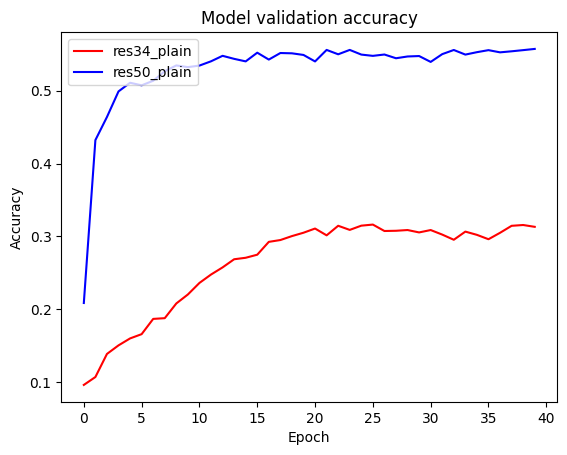

In [29]:
import matplotlib.pyplot as plt

plt.plot(history_res34_plain.history['val_accuracy'], 'r')
plt.plot(history_res50_plain.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['res34_plain', 'res50_plain'], loc='upper left')
plt.show()

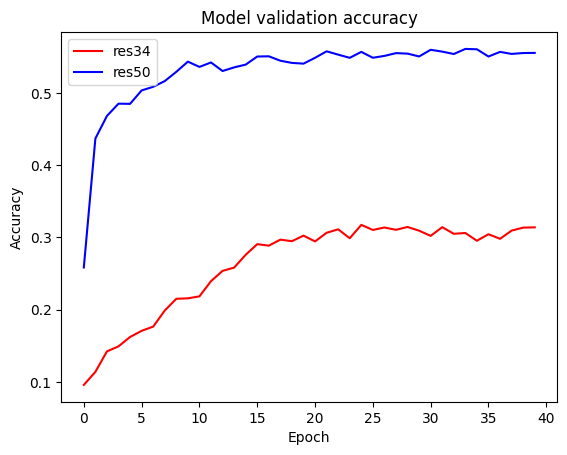

In [30]:
plt.plot(history_res34.history['val_accuracy'], 'r')
plt.plot(history_res50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['res34', 'res50'], loc='upper left')
plt.show()

# Cats vs Dogs 데이터셋 활용

In [31]:
# cats vs dogs 데이터셋 다운로드
import urllib3
urllib3.disable_warnings()

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [32]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)